#Building a Chatbot with Pytorch

Sumber : [github](https://github.com/UsmanNiazi/Chatbot-with-Pytorch/blob/main/chatbot.ipynb)

###Import Libray

In [25]:
import numpy as np
import random
import json
import nltk
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

###Creating Custom Functions
- create custom functions so that it is easy for us to implement afterwards

In [26]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return stemmer.stem(word.lower())

Nltk or natural language took kit is a really useful library that contains important classes that will be useful in any of your NLP task.

###Stemming
- There are different methods that we can use for stemming. Here we will use Porter Stemmer model form our NLTK Library.

In [27]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

###Bag of Words
- We will be splitting each word in the sentences and adding it to an array.
- We will loop over the each word in the all words array and the bog array corresponding to each word. If a word from the sentence is found in the all words array, 1 will be replaced at that index/position in bog array.

In [28]:
def bag_of_words(tokenized_sentence, words):
    """
    return bag of words array:
    1 for each known word that exists in the sentence, 0 otherwise
    example:
    sentence = ["hello", "how", "are", "you"]
    words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
    bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]
    """
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

During the the process , we will also use *nltk.word_tokenize()* which will convert a single sentence string into a list of word.

---

**Note**: we will pass lower case words to the stemmer so that words like Good and good (capitalized) won’t be labelled as different words.

###Loading the Data & Cleaning it

In [29]:
with open('Sadbot.json', 'r') as f:
    intents = json.load(f)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

This will separate all the tags & words into their separate lists

###Cleaning & Preparing the data using our custom functions

In [32]:
# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

625 patterns
161 tags: ['Cemburu', 'Date Recommendation_34', 'Date Recommendation_35', 'Date Recommendation_36', 'Date Recommendation_37', 'Date Recommendation_38', 'Date Recommendation_39', 'Date Recommendation_40', 'Date Recommendation_41', 'Date Recommendation_5', 'Date Recommendation_6', 'Date Recommendation_7', 'Date Recommendation_8', 'Feeling Lonely_1', 'Feeling Lonely_2', 'Feeling Lonely_3', 'Feeling Lonely_4', 'Feeling Lonely_5', 'Ghosting_1', 'Heartbreak_1', 'Heartbreak_10', 'Heartbreak_11', 'Heartbreak_12', 'Heartbreak_13', 'Heartbreak_14', 'Heartbreak_15', 'Heartbreak_16', 'Heartbreak_17', 'Heartbreak_18', 'Heartbreak_19', 'Heartbreak_2', 'Heartbreak_20', 'Heartbreak_3', 'Heartbreak_4', 'Heartbreak_5', 'Heartbreak_6', 'Heartbreak_7', 'Heartbreak_8', 'Heartbreak_9', 'Kepercayaan', 'Kesedihan_1', 'Kesedihan_2', 'Kesedihan_3', 'Kesedihan_4', 'Kesedihan_5', 'Kesetiaan', 'Love_1', 'Love_10', 'Love_11', 'Love_12', 'Love_13', 'Love_14', 'Love_15', 'Love_16', 'Love_17', 'Love_18', 

###Creating Training Data

In [33]:
# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

##PyTorch Model

---
Here we will be making a class to implement our custom neural network. It will be a feed forward neural Network which will have 3 Linear Layers and we will be using activation function “ReLU” .
- **Note:** 
We have used the super() function to inherit the properties of its parent class. 
This is an Object Oriented Programming (OOP) concept.

###Creating our Model

In [34]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

Here we have inherited a class from NN.Module because we will be customizing the model & its layers

###Assigning the Dataset to the Model
- We will use some Magic functions, write our class.
- You can read online about __getitem__ and __getitem__ magic funtions.

In [35]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

###Hyper Parameters
- Every Neural network has a set of hyper parameters that need to be set before use.
- Before Instantiating our Neural Net Class or Model that we wrote earlier, we will first define some hyper parameters which can be changed accordingly.

In [36]:
# Hyper-parameters 
num_epochs = 200
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

566 161


###Loss and Optimizer
- We will now Instantiate the model, loss and optimizer functions.
- Loss Function: Cross Entropy 
- Optimizer: Adam Optimizer

In [37]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###Training the Model

Epoch ke- 1
Epoch ke- 2
Epoch ke- 3
Epoch ke- 4
Epoch ke- 5
Epoch ke- 6
Epoch ke- 7
Epoch ke- 8
Epoch ke- 9
Epoch ke- 10
Epoch [10/200], Loss : 3.78, Acc: 11.36
Epoch ke- 11
Epoch ke- 12
Epoch ke- 13
Epoch ke- 14
Epoch ke- 15
Epoch ke- 16
Epoch ke- 17
Epoch ke- 18
Epoch ke- 19
Epoch ke- 20
Epoch [20/200], Loss : 3.43, Acc: 43.36
Epoch ke- 21
Epoch ke- 22
Epoch ke- 23
Epoch ke- 24
Epoch ke- 25
Epoch ke- 26
Epoch ke- 27
Epoch ke- 28
Epoch ke- 29
Epoch ke- 30
Epoch [30/200], Loss : 0.91, Acc: 73.60
Epoch ke- 31
Epoch ke- 32
Epoch ke- 33
Epoch ke- 34
Epoch ke- 35
Epoch ke- 36
Epoch ke- 37
Epoch ke- 38
Epoch ke- 39
Epoch ke- 40
Epoch [40/200], Loss : 0.89, Acc: 88.48
Epoch ke- 41
Epoch ke- 42
Epoch ke- 43
Epoch ke- 44
Epoch ke- 45
Epoch ke- 46
Epoch ke- 47
Epoch ke- 48
Epoch ke- 49
Epoch ke- 50
Epoch [50/200], Loss : 0.20, Acc: 94.40
Epoch ke- 51
Epoch ke- 52
Epoch ke- 53
Epoch ke- 54
Epoch ke- 55
Epoch ke- 56
Epoch ke- 57
Epoch ke- 58
Epoch ke- 59
Epoch ke- 60
Epoch [60/200], Loss : 0.03, 

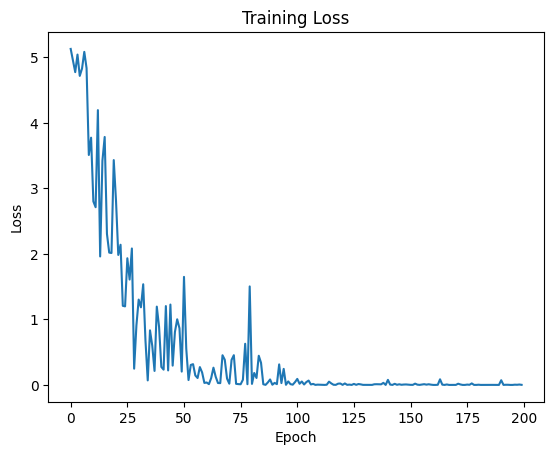

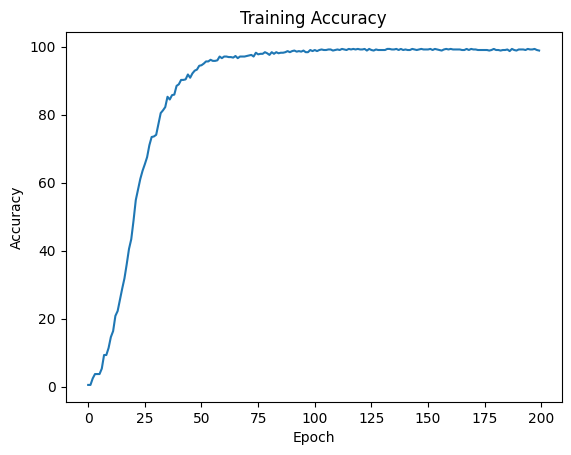

In [38]:
train_losses = [] # Menyimpan loss pada setiap epoch
train_acc = [] # Menyimpan akurasi pada setiap epoch

for epoch in range(num_epochs):
    print("Epoch ke-", epoch+1)
    n_correct = 0
    n_total = 0
    predicted_labels, ground_truth_labels = [], []

    for i, (words, labels) in enumerate(train_loader):
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)

        outputs = model(words)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        n_total += labels.shape[0]

        predicted_labels.append(predicted.cpu().detach().numpy())
        ground_truth_labels.append(labels.cpu().detach().numpy())

    accuracy = 100 * n_correct / n_total

    train_losses.append(loss.item())
    train_acc.append(accuracy)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss : {loss.item():.2f}, Acc: {accuracy:.2f}')

# Plot loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot accuracy
plt.plot(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()


In [39]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

###Saving the Trained Model

In [40]:
FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

training complete. file saved to data.pth


###Loading our Saved Model

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('Sadbot.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNet(
  (l1): Linear(in_features=566, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=161, bias=True)
  (relu): ReLU()
)

###Using the Chatbot

In [42]:
bot_name = "Sadbot"
print("Mau Curhat apa ni?^^ (type 'bye' to exit)")
while True:
    # sentence = "do you use credit cards?"
    sentence = input("You: ")
    if sentence == "bye":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")

Mau Curhat apa ni?^^ (type 'bye' to exit)
You: hallo
Sadbot: heii, ada yang perlu chatbot bantu
You: hallo sadbot
Sadbot: hallo, mau curhat apa ni sama sadbot?


KeyboardInterrupt: ignored

##Evaluasi